## 参考了几份代码

## word2vector测试语料text8
## SKIPGRAM的negative sampling demo 

In [1]:
import numpy as np
from tqdm import tqdm
from pprint import pprint
from collections import Counter
from scipy.special import softmax
from typing import List, Tuple, Iterator, Optional

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
from torch.autograd import Variable
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

%matplotlib inline

In [2]:
with open('text8.txt') as f:
    corpus = f.read()
print(corpus[:156])
len(corpus.split()),len(corpus)

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culott


(17005207, 100000000)

## dataset negative sampling

In [3]:
class SkipData:
    def __init__(self,
                 corpus,
                 window_size=5,
                 batch_size=64,
                 vocab_size=10000,
                 use_padding=True,
                 neg_size=10):
        self.corpus = corpus.strip().split()
        self.window_size = window_size
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.use_padding = use_padding
        self.neg_size = neg_size
        self.pad = "<PAD>"
        self.unk = "<UNK>"

        self.w2i = {self.pad: 0, self.unk: 1}
        self.i2w = {0: self.pad, 1: self.unk}

        self.distr = None
        self.vocab_range = None

        self.__build_vocabulary()

    def __build_vocabulary(self):
        print("building vocab of size: {}".format(self.vocab_size))

        word_count = Counter(self.corpus)
        vocab = [word for word, _ in sorted(word_count.items(),
                                            key=lambda x: x[1],
                                            reverse=True)[:self.vocab_size - 2]]
        self.distr = softmax(np.power
                             (1 / np.array([word_count[word] for word in vocab]), 0.75))
        # weight 

        for i, word in enumerate(vocab):
            self.w2i[word] = i + 2
            self.i2w[i + 2] = word

        self.vocab_size = len(vocab) + 2
        self.vocab_range = np.arange(self.vocab_size - 2)
        print("size build :{}".format(self.vocab_size))

    def __sample(self):
        return np.random.choice(self.vocab_range, size=self.neg_size, p=self.distr)  # dont forget to plus 2

    def __preprocess_batch(self, batch, use_padding=True):
        if use_padding and len(batch) < self.window_size * 2:
            batch = [self.pad] * (self.window_size * 2 - len(batch)) + batch

        output = [self.w2i.get(word, self.w2i[self.unk]) for word in batch]
        # dict.get:Return the value for key if key is in the dictionary, else default
        return torch.LongTensor(output)

    def indices_to_words(self, indices):
        return [[self.i2w[idx] for idx in batch] for batch in indices]

    def generate_batch(self):
        batch_inp, batch_target = [], []

        for i, center in enumerate(self.corpus):
            center_id = self.__preprocess_batch([center], use_padding=False)
            for context_id in self.__preprocess_batch(
                    self.corpus[max(i - self.window_size, 0):i] + self.corpus[i + 1:i + self.window_size + 1]):
                batch_inp.append(torch.LongTensor([center_id, context_id]))
                batch_target.append(1)  ## positive

                if len(batch_inp) == self.batch_size:
                    yield torch.stack(batch_inp), torch.Tensor(batch_target)
                    batch_inp, batch_target = [], []

            for negative_id in self.__sample():
                batch_inp.append(torch.LongTensor([center_id, negative_id + 2]))
                batch_target.append(0)  ## negative

                if len(batch_inp) == self.batch_size:
                    yield torch.stack(batch_inp), torch.Tensor(batch_target)
                    batch_inp, batch_target = [], []

        yield torch.stack(batch_inp), torch.Tensor(batch_target)

## Test Dataset

In [4]:
# test_a= SkipData(corpus, 5,16, 10000,use_padding=True, neg_size=10)
# next(enumerate(test_a.generate_batch()))

## Model

In [5]:
class SkipGramNSModel(nn.Module):
    def __init__(self,hidden_size,vocab_size):
        super().__init__()
        self.__hidden_size=hidden_size
        self.V=nn.Linear(vocab_size,hidden_size)
        self.U=nn.Linear(vocab_size,hidden_size)
    
    def forward(self,center,context):
        center_embedding=self.V(center)
        context_embedding=self.U(context)
        return torch.bmm(center_embedding.view(-1, 1, self.__hidden_size),
                         context_embedding.view(-1, self.__hidden_size, 1))[:, 0, 0]

In [6]:
class SkipGramNSTrainer:
    def __init__(self,corpus,
                window_size,
                hidden_size,
                vocab_size= 10000,
                use_padding = True,
                negative= 10,
                batch_size = 64,
                num_epochs = 1,
                learning_rate = 0.001,
                cuda_device= 0):
        self.iterator = SkipData(corpus, window_size, batch_size,vocab_size, use_padding, negative)
        self.vocab_size = self.iterator.vocab_size
        self.model = SkipGramNSModel(hidden_size, self.vocab_size)
        self.device = torch.device(f'cuda:{cuda_device}') if cuda_device >= 0 else torch.device('cpu')
        if cuda_device >= 0:
            self.model = self.model.cuda(self.device)
        self.num_epochs = num_epochs
        self.loss = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def train(self, print_every= 10000) :
        loss_box=[]

        for epoch in range(self.num_epochs):
            total_loss =torch.Tensor([0])
            print("Epoch {}/{}".format(epoch+1,self.num_epochs))

            for i ,(inp,target) in enumerate(self.iterator.generate_batch()):
                self.optimizer.zero_grad()
                inp_var = Variable(
                    F.one_hot(inp.to(self.device), self.vocab_size).float())
                out = self.model(inp_var[:, 0, :].view(-1, self.vocab_size)                                ,inp_var[:, 1, :].view(-1, self.vocab_size))
                loss=self.loss(out,target.to(self.device))
                loss.backward()
                self.optimizer.step()

                total_loss+=loss.detach().item()

                if i % print_every == 0:
                    print(f'{i} iterations... Current loss: {loss.detach().item():.2f}.')
                    
            loss_box.append(total_loss)
            print()
        
        return loss_box

In [7]:
trainer = SkipGramNSTrainer(
    corpus,
    window_size=5,
    hidden_size=50,
    use_padding=False,
    negative=5,
    num_epochs=10
)

building vocab of size: 10000
size build :10000


In [8]:
losses = trainer.train()

ns... Current loss: 0.27.
2370000 iterations... Current loss: 0.28.
2380000 iterations... Current loss: 0.23.
2390000 iterations... Current loss: 0.39.
2400000 iterations... Current loss: 0.35.
2410000 iterations... Current loss: 0.25.
2420000 iterations... Current loss: 0.30.
2430000 iterations... Current loss: 0.29.
2440000 iterations... Current loss: 0.59.
2450000 iterations... Current loss: 0.29.
2460000 iterations... Current loss: 0.35.
2470000 iterations... Current loss: 0.47.
2480000 iterations... Current loss: 0.38.
2490000 iterations... Current loss: 0.53.
2500000 iterations... Current loss: 0.47.
2510000 iterations... Current loss: 0.38.
2520000 iterations... Current loss: 0.34.
2530000 iterations... Current loss: 0.18.
2540000 iterations... Current loss: 0.15.
2550000 iterations... Current loss: 0.27.
2560000 iterations... Current loss: 0.67.
2570000 iterations... Current loss: 0.37.
2580000 iterations... Current loss: 0.17.
2590000 iterations... Current loss: 0.15.
2600000 

KeyboardInterrupt: 

In [16]:
def get_embedding(trainer, word):
    idx = trainer.iterator.w2i.get(word, None)
    if idx is not None:
        inp = torch.zeros(trainer.vocab_size)
        inp[idx] = 1
        inp = inp.to(trainer.device)
        
        return trainer.model.V(inp).detach().cpu().numpy() + \
                trainer.model.U(inp).detach().cpu().numpy()

In [17]:
def get_embeddings(trainer, words):
    embedding_matrix, words_found = [], []
    
    for word in words:
        emb = get_embedding(trainer, word)
        if emb is not None:
            embedding_matrix.append(emb)
            words_found.append(word)
    
    return np.vstack(embedding_matrix), words_found

In [18]:
def plot_embeddings(trainer, words):
    pca = PCA(2)
    embedding_matrix, words_found = get_embeddings(trainer, words)
    embedding_pca = pca.fit_transform(embedding_matrix)
    
    plt.figure(figsize=(10, 5))
    for word, embedding in zip(words_found, embedding_pca):
        plt.scatter(embedding[0], embedding[1], marker='x', color='red')
        plt.text(embedding[0] + 0.01, embedding[1] + 0.01, word, fontsize=9)
    plt.show()

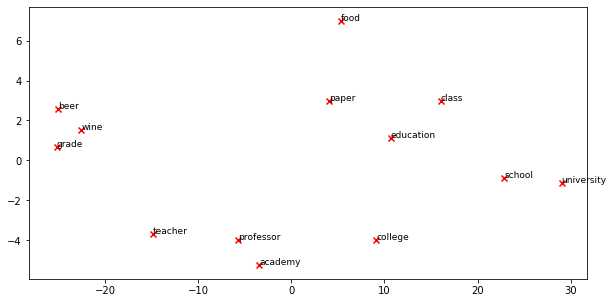

In [19]:
plot_embeddings(trainer, ['school', 'university', 'teacher', 'professor',
                          'grade', 'paper', 'class', 'lesson', 'exam', 'prom',
                          'academy', 'education', 'college', 'exams', 'gpa',
                          'food', 'spaghetti', 'beer', 'wine', 'burger', 'steak'])

In [20]:
embedding_matrix = np.vstack([
    get_embedding(trainer, word) for word in trainer.iterator.w2i
])

In [21]:
results = {}

with open('questions-words.txt', 'r') as f:
    for line in tqdm(f.read().split('\n')):
        analogy = line.split()
        if not analogy:
            continue
            
        if ':' in line:
            curr_topic = analogy[-1]
            results[curr_topic] = {'total': 0, 'correct': 0}
            continue
            
        if any(word.lower() not in trainer.iterator.w2i for word in analogy):
            continue

        results[curr_topic]['total'] += 1
        word1, word2, word3, word4 = analogy
        candidate = (get_embedding(trainer, word2.lower()) - get_embedding(trainer, word1.lower()) +
                     get_embedding(trainer, word3.lower())).reshape(1, -1)
        closest = trainer.iterator.i2w[
            np.argmin(cdist(candidate, embedding_matrix, metric='cosine').reshape(-1))
        ]

        if closest.lower() == word4.lower():
            results[curr_topic]['correct'] += 1

100%|██████████| 19559/19559 [00:21<00:00, 906.63it/s]


In [22]:
pprint(results)

{'capital-common-countries': {'correct': 35, 'total': 210},
 'capital-world': {'correct': 32, 'total': 200},
 'city-in-state': {'correct': 3, 'total': 420},
 'currency': {'correct': 0, 'total': 28},
 'family': {'correct': 18, 'total': 156},
 'gram1-adjective-to-adverb': {'correct': 0, 'total': 342},
 'gram2-opposite': {'correct': 0, 'total': 42},
 'gram3-comparative': {'correct': 8, 'total': 552},
 'gram4-superlative': {'correct': 1, 'total': 240},
 'gram5-present-participle': {'correct': 9, 'total': 552},
 'gram6-nationality-adjective': {'correct': 157, 'total': 1161},
 'gram7-past-tense': {'correct': 22, 'total': 756},
 'gram8-plural': {'correct': 14, 'total': 552},
 'gram9-plural-verbs': {'correct': 5, 'total': 240}}
